---

# **Sketch 2 Image Generator**
## A deep learning model that generates realistic images of birds from hand drawn sketches. 
## GitHub Repository: [Image Generator](https://github.com/EgeEken/Image-Generator)
### - Libraries: **PyTorch**, **OpenCV**, **NumPy**
### - MLOps: **Docker**, **MLflow**
### - GUI: **Gradio**
### - Dataset: [Kaggle Bird Dataset](https://www.kaggle.com/datasets/vinjamuripavan/bird-species)

---

In [43]:
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu129

Looking in indexes: https://download.pytorch.org/whl/cu129
   ---------------------------------------- 0.0/3.6 GB ? eta -:--:--
   ---------------------------------------- 0.0/3.6 GB 10.5 MB/s eta 0:05:42
   ---------------------------------------- 0.0/3.6 GB 8.2 MB/s eta 0:07:15
   ---------------------------------------- 0.0/3.6 GB 7.7 MB/s eta 0:07:41
   ---------------------------------------- 0.0/3.6 GB 7.5 MB/s eta 0:07:56
   ---------------------------------------- 0.0/3.6 GB 7.3 MB/s eta 0:08:06
   ---------------------------------------- 0.0/3.6 GB 7.3 MB/s eta 0:08:12
   ---------------------------------------- 0.0/3.6 GB 7.2 MB/s eta 0:08:17
   ---------------------------------------- 0.0/3.6 GB 7.1 MB/s eta 0:08:21
   ---------------------------------------- 0.0/3.6 GB 7.1 MB/s eta 0:08:23
   ---------------------------------------- 0.0/3.6 GB 7.1 MB/s eta 0:08:25
   ---------------------------------------- 0.0/3.6 GB 7.0 MB/s eta 0:08:27
   --------------------------------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install opencv-python matplotlib mlflow gradio

  Using cached docker-7.1.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached mako-1.3.10-py3-none-any.whl.metadata (2.9 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached pyasn1_modules-0.4.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached pyasn1-0.6.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached isodate-0.7.2-py3-none-any.whl.metadata (11 kB)
   ---------------------------------------- 0.0/26.7 MB ? eta -:--:--
   ----- ---------------------------------- 3.4/26.7 MB 18.0 MB/s eta 0:00:02
   ------------ --------------------------- 8.7/26.7 MB 22.1 MB/s eta 0:00:01
   ---------------------------- ----------- 18.9/26.7 MB 32.1 MB/s eta 0:00:01
   ---------------------------------------  26.5/26.7 MB 34.3 MB/s eta 0:00:01
   ---------------------------------------- 26.7/26.7 MB 32.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   --------------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
# Core
import os
from pathlib import Path
import random
import time

# Images
import cv2
import numpy as np
from matplotlib import pyplot as plt

# PyTorch
import torch
print(torch.__version__)
print(torch.cuda.is_available())
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Optional: MLflow
import mlflow


2.8.0+cu129
True


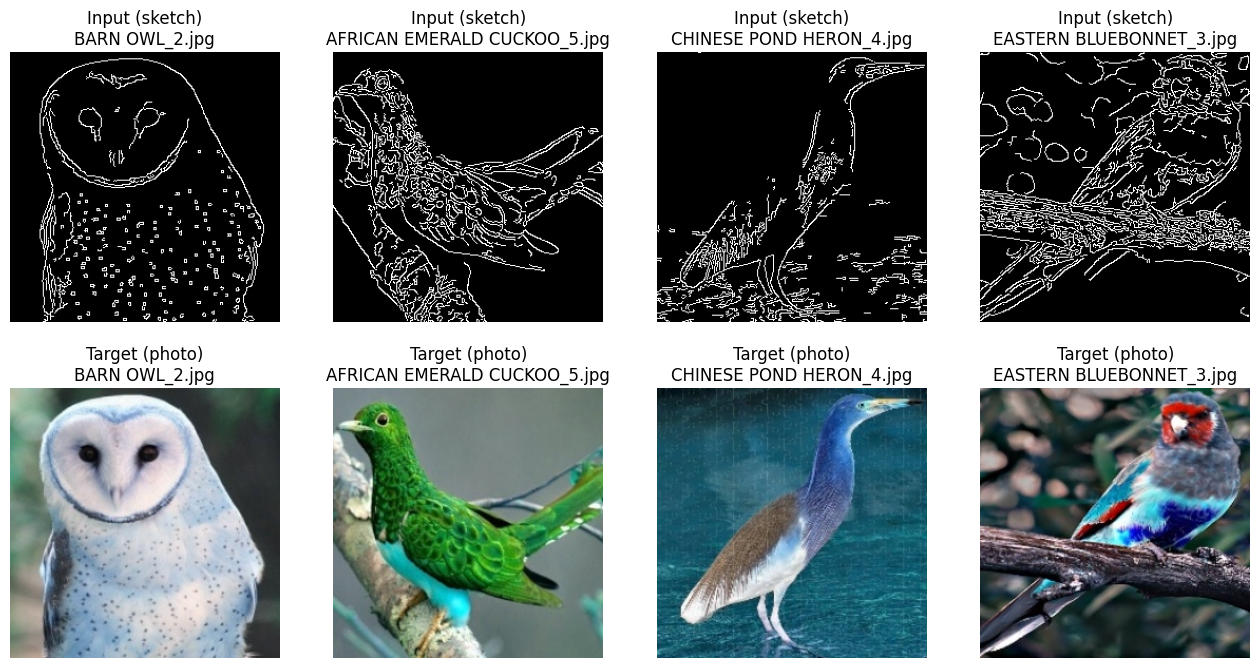

In [55]:
class Sketch2ImageDataset(Dataset):
    def __init__(self, input_dir, target_dir, image_size=(256,256)):
        self.inputs = sorted(list(Path(input_dir).glob("*.jpg")))
        self.targets = sorted(list(Path(target_dir).glob("*.jpg")))
        self.image_size = image_size
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        input_img = cv2.imread(str(self.inputs[idx]), cv2.IMREAD_GRAYSCALE)
        target_img = cv2.imread(str(self.targets[idx]))

        input_img = cv2.resize(input_img, self.image_size)
        target_img = cv2.resize(target_img, self.image_size)

        # Normalize 0-1 and convert to tensors
        input_img = torch.tensor(input_img/255.0, dtype=torch.float32).unsqueeze(0)  # 1xHxW
        target_img = torch.tensor(target_img/255.0, dtype=torch.float32).permute(2,0,1)  # 3xHxW
        return input_img, target_img, str(self.inputs[idx].name)

# Example usage:
train_dataset = Sketch2ImageDataset(
    "../data_prepared/train/inputs",
    "../data_prepared/train/targets"
)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Small validation set
val_dataset = Sketch2ImageDataset(
    "../data_prepared/valid/inputs",
    "../data_prepared/valid/targets"
)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)
val_single_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)


# Visualize 4 examples
inputs, targets, filenames = next(iter(val_loader))
fig, axes = plt.subplots(2, 4, figsize=(16,8))
for i in range(4):
    axes[0,i].imshow(inputs[i].permute(1,2,0), cmap='gray')
    axes[0,i].axis('off')
    axes[0,i].set_title(f"Input (sketch)\n{filenames[i]}")

    axes[1,i].imshow(targets[i].permute(1,2,0))
    axes[1,i].axis('off')
    axes[1,i].set_title(f"Target (photo)\n{filenames[i]}")
plt.show()


In [26]:
import torch.nn as nn

class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, features=64):
        super().__init__()

        # Encoder
        self.down1 = nn.Sequential(nn.Conv2d(in_channels, features, 4, 2, 1), nn.LeakyReLU(0.2))
        self.down2 = nn.Sequential(nn.Conv2d(features, features*2, 4, 2, 1), nn.BatchNorm2d(features*2), nn.LeakyReLU(0.2))
        self.down3 = nn.Sequential(nn.Conv2d(features*2, features*4, 4, 2, 1), nn.BatchNorm2d(features*4), nn.LeakyReLU(0.2))
        self.down4 = nn.Sequential(nn.Conv2d(features*4, features*8, 4, 2, 1), nn.BatchNorm2d(features*8), nn.LeakyReLU(0.2))
        
        # Decoder
        self.up1 = nn.Sequential(nn.ConvTranspose2d(features*8, features*4, 4, 2, 1), nn.BatchNorm2d(features*4), nn.ReLU())
        self.up2 = nn.Sequential(nn.ConvTranspose2d(features*8, features*2, 4, 2, 1), nn.BatchNorm2d(features*2), nn.ReLU())
        self.up3 = nn.Sequential(nn.ConvTranspose2d(features*4, features, 4, 2, 1), nn.BatchNorm2d(features), nn.ReLU())
        self.final = nn.ConvTranspose2d(features*2, out_channels, 4, 2, 1)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        u1 = self.up1(d4)
        u2 = self.up2(torch.cat([u1, d3], dim=1))
        u3 = self.up3(torch.cat([u2, d2], dim=1))
        out = self.final(torch.cat([u3, d1], dim=1))
        return self.tanh(out)


In [27]:
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")

Number of batches in train_loader: 21159
Number of batches in val_loader: 657


In [ ]:
loader = val_loader
epochs = 1
learning_rate = 1e-5



device = "cuda" if torch.cuda.is_available() else "cpu"
generator = UNetGenerator().to(device)
optimizer = torch.optim.AdamW(generator.parameters(), lr=learning_rate, betas=(0.5,0.999))
criterion = nn.L1Loss()


start = time.time()
for epoch in range(epochs):
    for i, (x, y, _) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = generator(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        # each 10% slice of the whole epoch:
        if i % (len(loader)//10) == 0:
            print(f"[{epoch+1}/{epochs}] \t|\t Batch {i} / {len(loader)} \t|\t Loss: {loss.item():.4f} \t|\t Time Elapsed: {time.time() - start:.2f} seconds")

    print(f"\nEpoch {epoch+1} / {epochs} completed in {time.time() - start:.2f} seconds\n")


[1/1] 	|	 Batch 0 / 657 	|	 Loss: 0.6039 	|	 Time Elapsed: 0.23 seconds
[1/1] 	|	 Batch 65 / 657 	|	 Loss: 0.2306 	|	 Time Elapsed: 4.85 seconds
[1/1] 	|	 Batch 130 / 657 	|	 Loss: 0.1756 	|	 Time Elapsed: 9.44 seconds
[1/1] 	|	 Batch 195 / 657 	|	 Loss: 0.2202 	|	 Time Elapsed: 13.84 seconds
[1/1] 	|	 Batch 260 / 657 	|	 Loss: 0.2098 	|	 Time Elapsed: 18.25 seconds
[1/1] 	|	 Batch 325 / 657 	|	 Loss: 0.2186 	|	 Time Elapsed: 22.85 seconds
[1/1] 	|	 Batch 390 / 657 	|	 Loss: 0.2046 	|	 Time Elapsed: 27.35 seconds
[1/1] 	|	 Batch 455 / 657 	|	 Loss: 0.1967 	|	 Time Elapsed: 31.83 seconds
[1/1] 	|	 Batch 520 / 657 	|	 Loss: 0.1482 	|	 Time Elapsed: 36.30 seconds
[1/1] 	|	 Batch 585 / 657 	|	 Loss: 0.2528 	|	 Time Elapsed: 40.80 seconds
[1/1] 	|	 Batch 650 / 657 	|	 Loss: 0.1857 	|	 Time Elapsed: 45.44 seconds

Epoch 1 / 1 completed in 45.84 seconds



In [72]:
def run_model_on_image(model, image_array, device=device):
    model.eval()
    img = torch.tensor(image_array/255.0, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # 1x1xHxW

    with torch.no_grad():
        output = model(img)
    output = output.squeeze(0).permute(1,2,0).cpu().numpy()  # HxWx3
    output = (output * 255).astype(np.uint8)
    return output

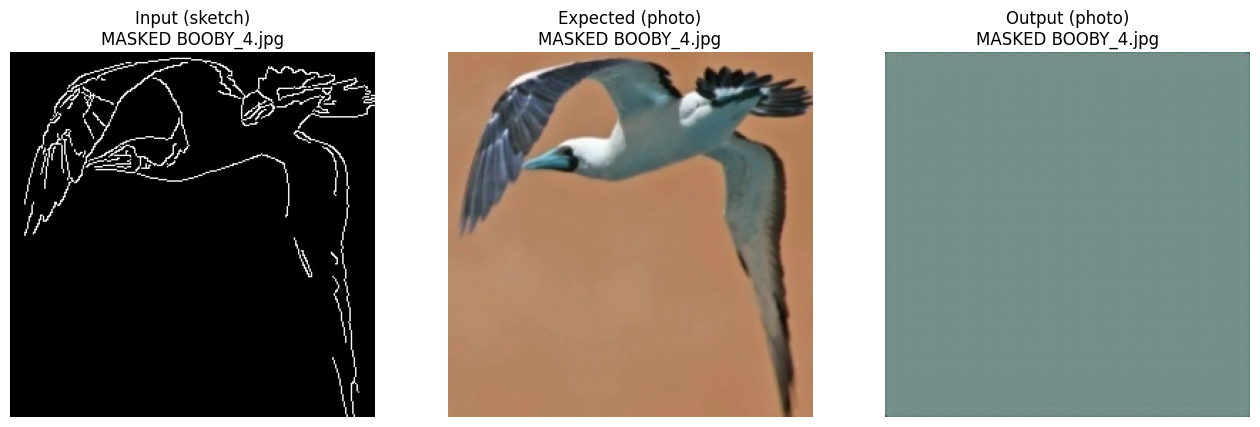

In [89]:
input_image, expected_output, input_filename = next(iter(val_single_loader))
input_image = input_image.cpu().numpy().reshape((256, 256))
expected_output = expected_output.squeeze(0).permute(1,2,0)  # 3xHxW
output_image = run_model_on_image(generator, input_image)

fig, axes = plt.subplots(1, 3, figsize=(16,6))
axes[0].imshow(input_image, cmap='gray')
axes[0].axis('off')
axes[0].set_title(f"Input (sketch)\n{input_filename[0]}")

axes[1].imshow(expected_output)
axes[1].axis('off')
axes[1].set_title(f"Expected (photo)\n{input_filename[0]}")

axes[2].imshow(output_image)
axes[2].axis('off')
axes[2].set_title(f"Output (photo)\n{input_filename[0]}")

plt.show()

---

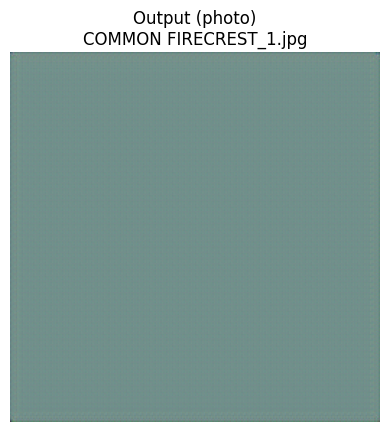

In [75]:
output_image = run_model_on_image(generator, input_image)
plt.imshow(output_image)
plt.axis('off')
plt.title(f"Output (photo)\n{input_filename[0]}")
plt.show()

In [ ]:
torch.save(generator.state_dict(), "generator.pth")
# To load later:
# generator.load_state_dict(torch.load("generator.pth"))
